#### Inicialização de variáveis e importação de bibliotecas

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras import layers, Input
from keras.regularizers import l2



AUTOTUNE = tf.data.AUTOTUNE

batch_size = 32
img_height = 220
img_width = 220
data_dir='data/cuted/'
predict_dir='predict/'

2024-04-17 10:56:36.735697: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 10:56:36.737173: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 10:56:36.806777: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 10:56:37.083032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 10:56:38.129978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

#### Definição dos diretórios de treinamento e validação
    



O primeiro conjunto de dados, ```train_ds```, é para treinamento. Lendo imagens do diretório especificado em data_dir, dividindo 20% dos dados para validação (deixando 80% para treinamento) com a opção ```validation_split=0.2```, e especificando que este é o conjunto de "treinamento" com ```subset="training"```. Você também está definindo uma semente para a divisão dos dados com ```seed=123```, redimensionando todas as imagens para o tamanho especificado em ```(img_height, img_width)```, e definindo o tamanho do lote com ```batch_size```.

O segundo conjunto de dados, val_ds, é para validação. As opções são as mesmas, exceto que subset é definido como "validation", indicando que este conjunto de dados deve ser a parte de validação da divisão.

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4467 files belonging to 2 classes.
Using 3574 files for training.
Found 4467 files belonging to 2 classes.
Using 893 files for validation.


2024-04-17 10:56:39.678733: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 10:56:39.679031: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
class_names = train_ds.class_names
print(class_names)

['header', 'non-header']


#### Plotagem de imagens de treinamento e suas classes



Criação de gráfico de 3x3 que mostra 9 imagens de treinamento e suas classes correspondentes. Usando o conjunto de dados de treinamento, train_ds, e iterando sobre ele para obter um lote de imagens e rótulos. Permitindo a plotagem das imagens e rótulos correspondentes.

2024-04-17 10:56:42.061321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


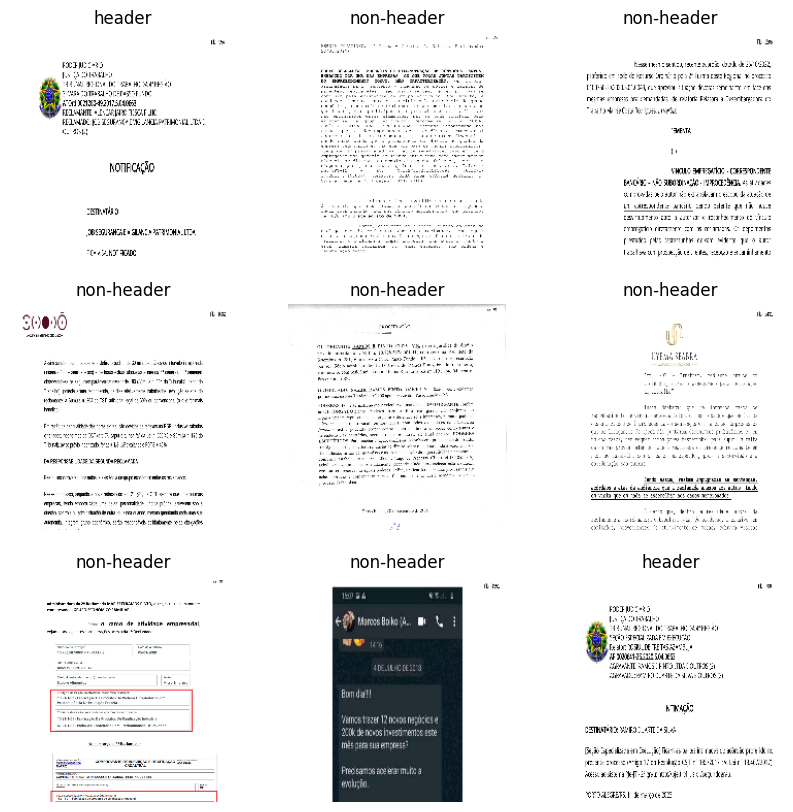

In [4]:
import matplotlib.pyplot as plt
i=0
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### Otimização de desempenho dos conjuntos de dados


```.cache()```: mantém os dados na memória depois de serem carregados do disco. Isso garante que o conjunto de dados não precisa ser recarregado a cada época, melhorando o desempenho.  

```.shuffle(1000)```: randomiza a ordem dos exemplos no conjunto de dados de treinamento. Isso é importante para evitar que o modelo aprenda dependências indesejadas da ordem dos exemplos.  

```.prefetch(buffer_size=AUTOTUNE)``` antecipa o carregamento dos dados para a próxima época enquanto o modelo está treinando na época atual. Isso melhora o desempenho ao reduzir o tempo de inatividade entre as épocas. AUTOTUNE permite que o TensorFlow escolha automaticamente o número de lotes para antecipar.  


Para o conjunto de dados de validação, apenas ```.cache()``` e ```.prefetch(buffer_size=AUTOTUNE)``` são usados, pois não é necessário embaralhar os exemplos.

In [5]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Padronização dos dados



Normalização dos valores de pixel das imagens para que estejam no intervalo de [0, 1]. Isso é feito dividindo cada valor de pixel por 255, pois um canal RGB tem valores de pixel no intervalo [0, 255].

In [6]:
normalization_layer = keras.layers.Rescaling(1./255)

#### Definição do Modelo



```num_classes = len(class_names)```: Define o número de classes que o modelo precisa prever. Isso é baseado no número de nomes de classes fornecidos.

```model = Sequential()```: Inicia a definição de um novo modelo sequencial. Modelos sequenciais são uma pilha linear de camadas.

```Input(shape=(img_height, img_width, 3))```: Define a forma da entrada para o modelo. Neste caso, a entrada é uma imagem colorida (3 canais para vermelho, verde e azul) com altura e largura especificadas.

```layers.Rescaling(1./255)```: Reescala os valores de pixel da imagem para o intervalo [0,1].

```layers.Conv2D(16, 3, padding='same', activation='relu')```: Adiciona uma camada convolucional 2D com 16 filtros, um tamanho de kernel de 3 e ativação ReLU.

```layers.MaxPooling2D()```: Adiciona uma camada de pooling para reduzir a dimensionalidade espacial.

As próximas duas camadas Conv2D e MaxPooling2D são semelhantes à 5ª e 6ª linha, mas com mais filtros na camada convolucional.

```layers.Flatten()```: Achata a saída da última camada de pooling para um vetor unidimensional.

```layers.Dense(128, activation='relu')```: Adiciona uma camada densamente conectada com 128 neurônios e ativação ReLU.

```layers.Dense(num_classes)```: Adiciona uma camada densa final com um número de neurônios igual ao número de classes. Esta camada produz a saída do modelo.

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/home/daviga/projects/machine-learning/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2024-04-17 10:56:52.492641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 52 of 1000
2024-04-17 10:57:01.133746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-04-17 10:57:01.747866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


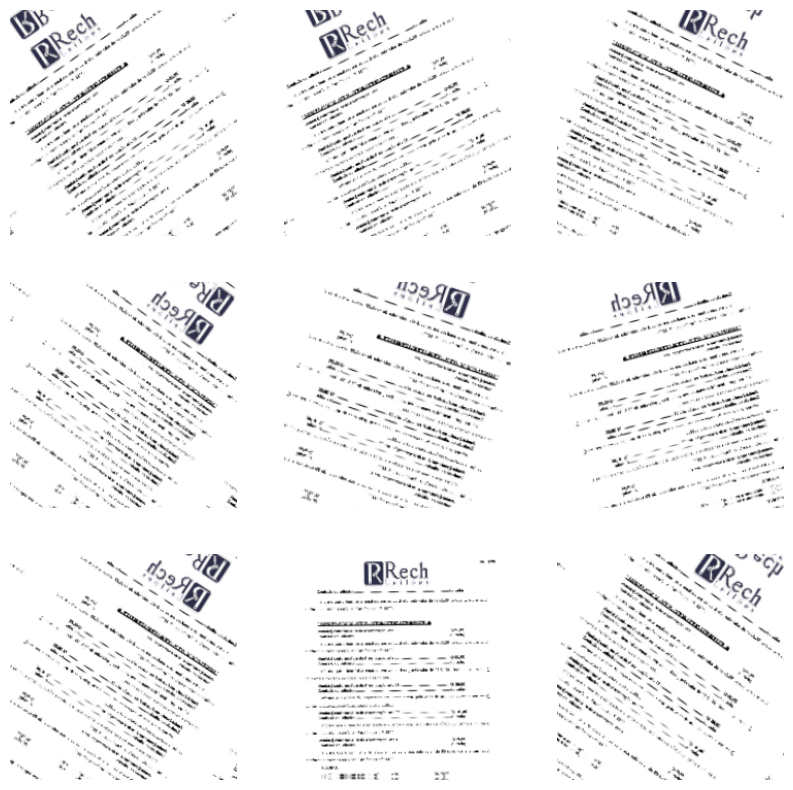

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [9]:
num_classes = len(class_names)

model = Sequential([
  layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 220, 220, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 220, 220, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 220, 220, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 220, 220, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 55, 55, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,779,394 (22.05 MB)

 Trainable params: 5,779,394 (22.05 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
epochs = 60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 79s 692ms/step - accuracy: 0.7959 - loss: 1.3410 - val_accuracy: 0.8119 - val_loss: 0.7355
Epoch 2/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 74s 623ms/step - accuracy: 0.7945 - loss: 0.7165 - val_accuracy: 0.8119 - val_loss: 0.6073
Epoch 3/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 624ms/step - accuracy: 0.7981 - loss: 0.6173 - val_accuracy: 0.8544 - val_loss: 0.4430
Epoch 4/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 65s 575ms/step - accuracy: 0.8009 - loss: 0.5986 - val_accuracy: 0.9093 - val_loss: 0.3902
Epoch 5/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 76s 524ms/step - accuracy: 0.8738 - loss: 0.4170 - val_accuracy: 0.9362 - val_loss: 0.3706
Epoch 6/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 83s 537ms/step - accuracy: 0.8723 - loss: 0.4403 - val_accuracy: 0.9160 - val_loss: 0.3703
Epoch 7/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 58s 522ms/step - accuracy: 0.8938 - loss: 0.3877 - val_accuracy: 0.9272 - val_loss: 0.3508
Epoch 8/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 60s 534ms/step - accuracy: 0.9087 - loss: 0

In [12]:
model.save('model.keras')

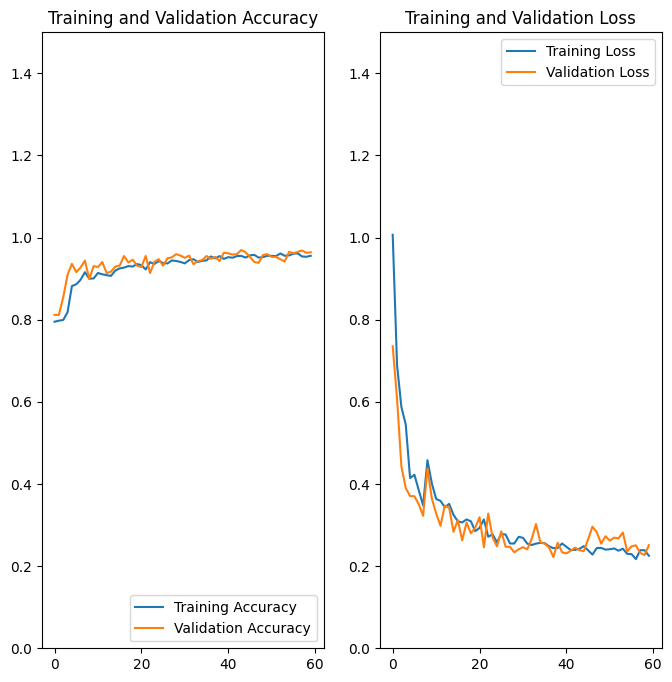

In [13]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1.5]) 

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim([0, 1.5])
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step


2024-04-17 12:18:34.102574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


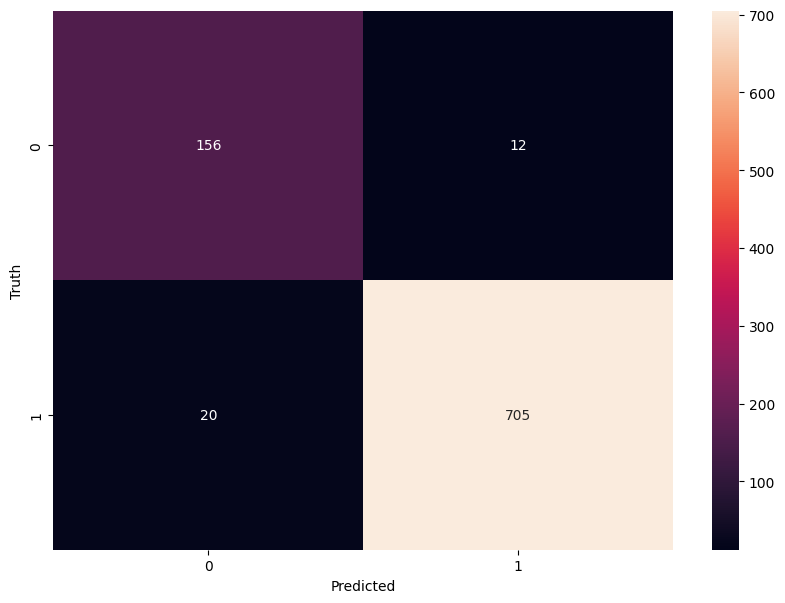

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Suponha que você tenha um modelo treinado chamado 'model'
# E você usa o conjunto de validação para fazer previsões
y_pred = model.predict(val_ds)

# Converta as previsões em rótulos de classe
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtenha os rótulos verdadeiros do conjunto de validação
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Calcule a matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Visualize a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [15]:
import numpy as np

# Suponha que `model.predict(val_ds)` retorne um array bidimensional, onde cada linha representa uma amostra e cada coluna representa a probabilidade de uma classe
predictions = model.predict(val_ds)

# Encontre a classe com a maior probabilidade para cada amostra
predicted_classes = np.argmax(predictions, axis=1)

# Encontre a probabilidade da classe prevista para cada amostra
predicted_probabilities = np.max(predictions, axis=1)

import os
import tensorflow as tf

from pathlib import Path

data_dir = Path("data/cuted")

batch_size = 32
img_height = 180
img_width = 180

# Obtenha a lista de todos os arquivos de imagem
all_image_paths = list(data_dir.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# Divida a lista de caminhos de imagem em conjuntos de treinamento e validação
train_image_paths = all_image_paths[:int(len(all_image_paths)*0.8)]
val_image_paths = all_image_paths[int(len(all_image_paths)*0.8):]

# Crie um tf.data.Dataset a partir dos caminhos de imagem
list_ds = tf.data.Dataset.from_tensor_slices(val_image_paths)

# Função para carregar e pré-processar as imagens
def process_path(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [img_height, img_width])
  img /= 255.0
  return img

# Crie um tf.data.Dataset de imagens
val_ds = list_ds.map(process_path).batch(batch_size)

# Agora você tem uma lista `val_image_paths` contendo os caminhos de todas as imagens no conjunto de validação
# Você pode usar esta lista para obter o nome do arquivo de imagem durante a predição
for i in range(len(predicted_classes)):
  
    print(f"Sample {os.path.basename(val_image_paths[i])}: Class {class_names[predicted_classes[i]]}, Probability {predicted_probabilities[i]}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step
Sample page_160_p7.png: Class non-header, Probability 0.9999972581863403
Sample page_322_p7.png: Class non-header, Probability 1.0
Sample page_2652_p7.png: Class non-header, Probability 0.934444785118103
Sample page_1553_p7.png: Class non-header, Probability 0.9999998807907104
Sample page_2511_p7.png: Class non-header, Probability 0.9581400156021118
Sample page_986_p3_cropped.png: Class header, Probability 0.5895876884460449
Sample page_399_p5_cropped.png: Class header, Probability 0.9123846888542175
Sample page_384_p3_cropped.png: Class header, Probability 0.9968152642250061
Sample page_452_p5_cropped.png: Class non-header, Probability 0.9999974966049194
Sample page_679_p1_cropped.png: Class non-header, Probability 0.9999986886978149
Sample page_2547_p7.png: Class non-header, Probability 0.9999946355819702
Sample page_736_p3_cropped.png: Class non-header, Probability 0.9963471293449402
Sample page_788_p1_cropped.png: Class non-header, Probabili